# Sensitivity encoded MRI reconstruction
`Nan-kuei Chen`  
`2021-04-15` 

* __The goal is to demonstrate the use of SENSE reconstruction to recover full-FOV images (i.e., free-from aliasing artifact) from under-sampled k-space data__
* __The matlab version of this program is described [here](https://drive.google.com/file/d/1zLqreSDZ4RoXTw0RQiRo72aaZKwjIM-z/view?usp=sharing); and k-space data in matlab format is available in [google drive](https://drive.google.com/file/d/1Rz33UxGSabPlTZY9uH77Rb2vlS4R9q8A/view?usp=sharing )__

## Section 1
* We load two sets of fully-sampled k-space data: 4-shot spin-echo echo-planar imaging obtained at different echo times.
* The matrix size for each echo image is $128 \times 128 \times 8 $  (in-plane matrix size: 128x128; number of RF channels: 8)

In [1]:
using PyPlot
using FFTW
using Statistics

In [2]:
fid = open("data/kdata_4s_seepi","r");
kdata_4s_seepi = zeros(ComplexF64, 128,128,8,2);
read!(fid,kdata_4s_seepi);
close(fid);
@show size(kdata_4s_seepi);

size(kdata_4s_seepi) = (128, 128, 8, 2)


In [3]:
kdata_echo1 = kdata_4s_seepi[:,:,:,1];  # k-space data for the first echo 
kdata_echo2 = kdata_4s_seepi[:,:,:,2];  # k-space data for the second echo

In [4]:
imgdata_echo1 = fftshift(fft(fftshift(kdata_echo1,[1,2]),[1,2]),[1,2]); # Image reconstruction with Fourier transform
imgdata_echo2 = fftshift(fft(fftshift(kdata_echo2,[1,2]),[1,2]),[1,2]);

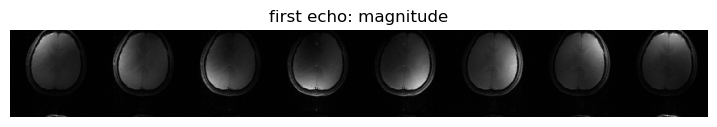

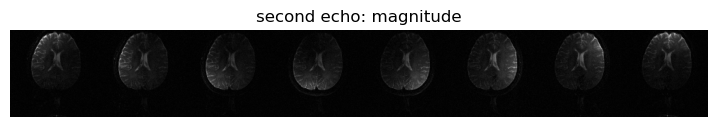

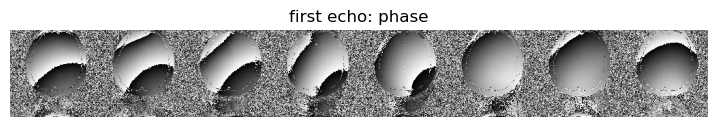

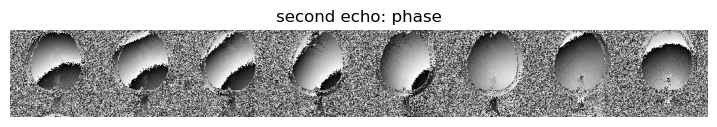

In [5]:
# showing the magnitude and phase information of both echo images
function convertImage(input)
    showImage = reverse(permutedims(input,[2,1,3]),dims=1);
    showImage = reshape(showImage, size(showImage,1), size(showImage,2)*size(showImage,3)); 
    
end

figure(1,figsize=(9,3));imshow(abs.(convertImage(imgdata_echo1)), cmap="gray"); axis("off"); title("first echo: magnitude")
figure(2,figsize=(9,3));imshow(abs.(convertImage(imgdata_echo2)), cmap="gray");  axis("off") ; title("second echo: magnitude")
figure(3,figsize=(9,3));imshow(angle.(convertImage(imgdata_echo1)), cmap="gray");  axis("off"); title("first echo: phase")
figure(4,figsize=(9,3));imshow(angle.(convertImage(imgdata_echo2)), cmap="gray");  axis("off"); title("second echo: phase");


## Section 2
* Here we compute coil sensitivity profiles from the first echo images (fully-sampled in k-space). The information could be used in SENSE reconstruction of under-sampled k-space data (see sections 3 and 4)

We could combine the information from 8 RF channels with "root-mean-square"

In [6]:
function rmsCombineDataCoils(inputdata)
    szl = ndims(inputdata)
    if szl == 2
        outputdata = deepcopy(inputdata);
    end
    if szl > 2
        outputdata = sqrt.(mean(abs.(inputdata).^2,dims=szl));
    end
    return outputdata
end;

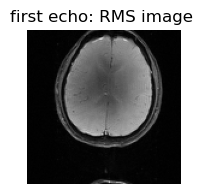

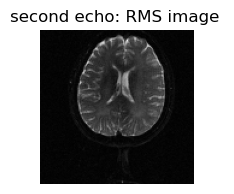

In [7]:
# Showing the RMS images from both echoes (fully-sampled in k-space)
combinedData_echo1 = rmsCombineDataCoils(imgdata_echo1);
combinedData_echo2 = rmsCombineDataCoils(imgdata_echo2);
figure(1,figsize=(2,2));imshow(convertImage(combinedData_echo1),cmap="gray"); axis("off"); title("first echo: RMS image ")
figure(2,figsize=(2,2));imshow(convertImage(combinedData_echo2),cmap="gray"); axis("off"); title("second echo: RMS image ");

Calculation of coil sensitivity profiles from the first echo image

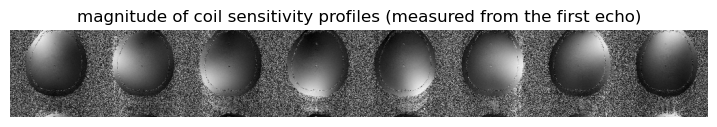

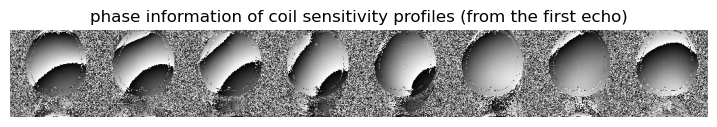

In [8]:
coilSensitivityProfile1 = imgdata_echo1./combinedData_echo1;
figure(1,figsize=(9,3));imshow(abs.(convertImage(coilSensitivityProfile1)), cmap="gray"); axis("off"); title("magnitude of coil sensitivity profiles (measured from the first echo)")
figure(2,figsize=(9,3));imshow(angle.(convertImage(coilSensitivityProfile1)), cmap="gray"); axis("off"); title("phase information of coil sensitivity profiles (from the first echo)");

## Section 3
* Although we have fully-sampled k-space data for the second echo image, here we only use 50% of its k-space data (i.e., simulating under-sampled scan)
* After Fourier transform, images reconstructed from under-sampled k-space show aliasing artifact

Assuming that we have acquied only 50% of the k-space data for the second echo image (with only odd ky lines acquired), what would the reconstructed images look like?

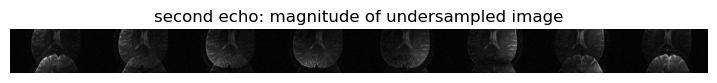

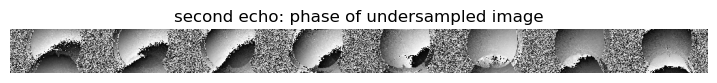

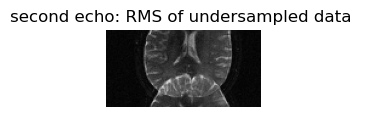

In [9]:
kData_acquired = kdata_echo2[:,1:2:end,:];
imgdata_acquired = fftshift(fft(fftshift(kData_acquired,[1,2]),[1,2]),[1,2]);
figure(1,figsize=(9,3));imshow(abs.(convertImage(imgdata_acquired)), cmap="gray"); axis("off"); title("second echo: magnitude of undersampled image")
figure(2,figsize=(9,3));imshow(angle.(convertImage(imgdata_acquired)), cmap="gray"); axis("off"); title("second echo: phase of undersampled image")
figure(3,figsize=(2,2));imshow(convertImage(rmsCombineDataCoils(imgdata_acquired)),cmap="gray"); axis("off"); title("second echo: RMS of undersampled data ");

Would zero-filling k-space data change anything?

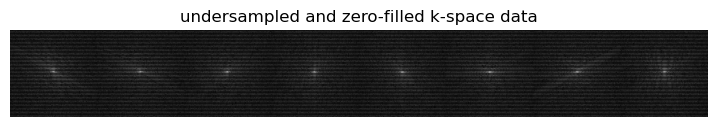

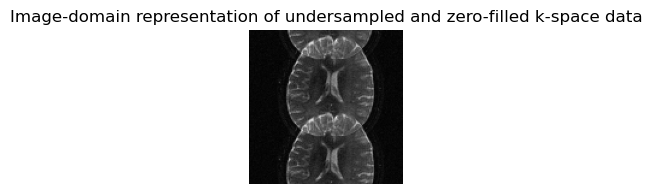

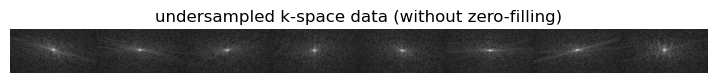

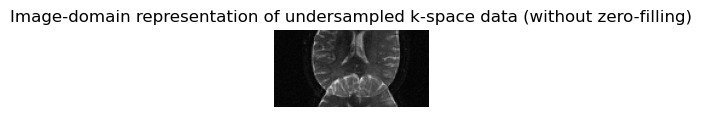

In [10]:
kData_acquired_zeroFilled = zeros(ComplexF64,size(kData_acquired)[1],size(kData_acquired)[2]*2,size(kData_acquired)[3]);
kData_acquired_zeroFilled[:,1:2:end,:] = kData_acquired;
imgdata_acquired_zeroFilled = fftshift(fft(fftshift(kData_acquired_zeroFilled,[1,2]),[1,2]),[1,2]);

figure(1,figsize=(9,3));imshow(abs.(convertImage(kData_acquired_zeroFilled)).^0.3, cmap="gray"); axis("off"); title("undersampled and zero-filled k-space data")
figure(2,figsize=(2,2));imshow(convertImage(rmsCombineDataCoils(imgdata_acquired_zeroFilled)),cmap="gray"); axis("off"); title("Image-domain representation of undersampled and zero-filled k-space data");
figure(3,figsize=(9,3));imshow(abs.(convertImage(kData_acquired)).^0.3, cmap="gray"); axis("off"); title("undersampled k-space data (without zero-filling)")
figure(4,figsize=(2,2));imshow(convertImage(rmsCombineDataCoils(imgdata_acquired)),cmap="gray"); axis("off"); title("Image-domain representation of undersampled k-space data (without zero-filling)");

## Section 4
* Here we use coil sensitivity information estimated from the first echo image (fully-sampled: section 2) to remove aliasing artifact in under-sampled k-space data of the second echo image (section 3)

SENSE reconstruction for recovering full-FOV images from under-sampled data using the coil sensitivity profiles

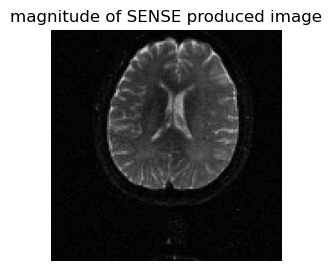

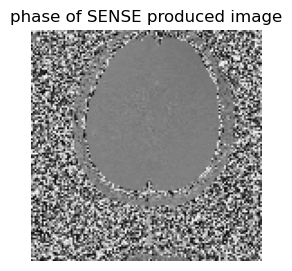

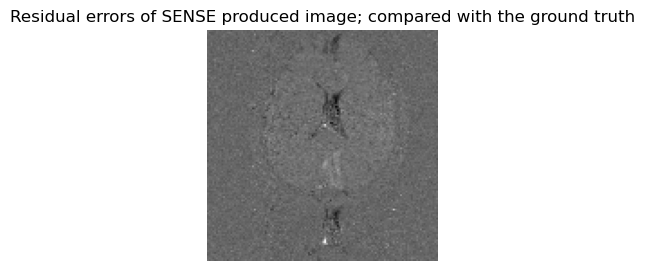

In [20]:
sense_reconstructed_image = zeros(ComplexF64,size(kData_acquired)[1],size(kData_acquired)[2]*2);

for cntx = 1:size(kData_acquired)[1]
    for cnty = 1: size(kData_acquired)[2]
        mat1 = imgdata_acquired_zeroFilled[cntx,cnty,:];
        mat2 = hcat(coilSensitivityProfile1[cntx,cnty,:],coilSensitivityProfile1[cntx,cnty+size(kData_acquired)[2],:])
        mat3 = mat2\mat1;
        sense_reconstructed_image[cntx,cnty]=mat3[1];
        sense_reconstructed_image[cntx,cnty+size(kData_acquired)[2]]=mat3[2];
    end
end

figure(1,figsize=(3,3));imshow(abs.(sense_reconstructed_image)',cmap="gray", origin="lower"); axis("off"); title("magnitude of SENSE produced image")
figure(2,figsize=(3,3));imshow(angle.(sense_reconstructed_image)',cmap="gray", origin="lower") ; axis("off"); title("phase of SENSE produced image")
figure(3,figsize=(3,3));imshow((abs.(sense_reconstructed_image)*2-combinedData_echo2[:,:,1])',cmap="gray", origin="lower"); axis("off"); title("Residual errors of SENSE produced image; compared with the ground truth");

### Questions and exercise

* Can we simply average information from 8 RF channels instead using room-mean-square?
* What if we have only 4 RF channels? will the SENSE reconstruction work?
* What if we have only 2 RF channels? will the SENSE reconstruction work?
* Should we smooth coil sensitivity profiles? Will that improve the SNR of SENSE-reconstructed images?
* How can we use regularization to reduce noise amplification?
* Can we reconstruct full FOV images from only 25% of the k-space data (e.g., $k_y$ line # 1, 5, 9 ...)?
